In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix

from load_data import load_problem

PICKLE_PATH = '../data/lasso_regression/lasso_data.pickle'

In [2]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_train = featurize(x_train)
X_val = featurize(x_val)

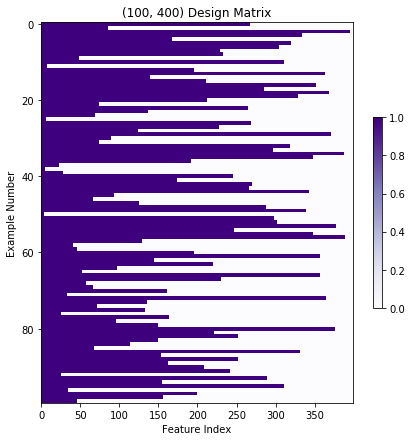

In [3]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_title("({0}, {1}) Design Matrix".format(X_train.shape[0], X_train.shape[1]))
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
temp = ax.imshow(X_train, cmap=plt.cm.Purples, aspect="auto")
plt.colorbar(temp, shrink=0.5);

## Ridge Regression

### Ridge Regression - Question 1

In [4]:
class RidgeRegression(BaseEstimator, RegressorMixin):
	""" ridge regression"""

	def __init__(self, l2reg=1):
		if l2reg < 0:
			raise ValueError('Regularization penalty should be at least 0.')
		self.l2reg = l2reg

	def fit(self, X, y=None):
		n, num_ftrs = X.shape
		# convert y to 1-dim array, in case we're given a column vector
		y = y.reshape(-1)
		def ridge_obj(w):
			predictions = np.dot(X,w)
			residual = y - predictions
			empirical_risk = np.sum(residual**2) / n
			l2_norm_squared = np.sum(w**2)
			objective = empirical_risk + self.l2reg * l2_norm_squared
			return objective
		self.ridge_obj_ = ridge_obj

		w_0 = np.zeros(num_ftrs)
		self.w_ = minimize(ridge_obj, w_0).x
		return self

	def predict(self, X, y=None):
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		return np.dot(X, self.w_)

	def score(self, X, y):
		# Average square error
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		residuals = self.predict(X) - y
		return np.dot(residuals, residuals)/len(y)

In [5]:
def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):

	# Fit with sklearn -- need to multiply l2_reg by sample size, since their
	# objective function has the total square loss, rather than average square
	# loss.
	n = X_train.shape[0]
	sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
	sklearn_ridge.fit(X_train, y_train)
	sklearn_ridge_coefs = sklearn_ridge.coef_

	# Now run our ridge regression and compare the coefficients to sklearn's
	ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
	ridge_regression_estimator.fit(X_train, y_train)
	our_coefs = ridge_regression_estimator.w_

	print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

In [6]:
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1.5)

Hoping this is very close to 0:4.6884282980897267e-11


In [7]:
default_params = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

def do_grid_search_ridge(X_train, y_train, X_val, y_val, params = default_params):

	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'l2reg':params}]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

In [8]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)

In [9]:
results

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000010,0.172464,0.006752
2,0.000100,0.171345,0.006774
3,0.001000,0.162705,0.008285
4,0.010000,0.141887,0.032767
5,0.100000,0.144566,0.094953
6,1.000000,0.171068,0.197694
7,1.300000,0.179521,0.216591
8,1.600000,0.187993,0.233450
9,1.900000,0.196361,0.248803


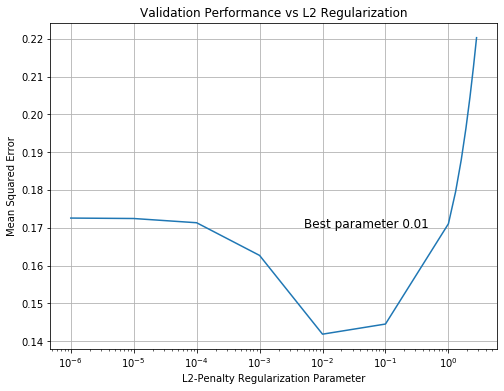

In [10]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l2reg']), fontsize = 12);

### Ridge Regression - Question 2

In [11]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

In [12]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

	fig, ax = plt.subplots(figsize = (12,8))
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, color="k", label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

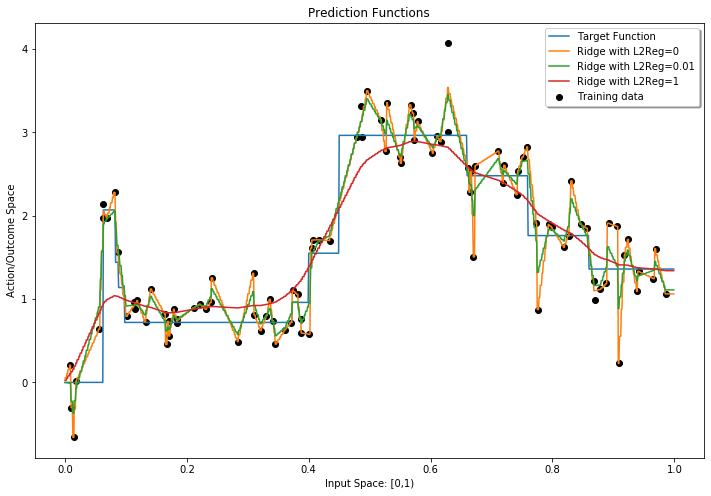

In [13]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best");

In [14]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

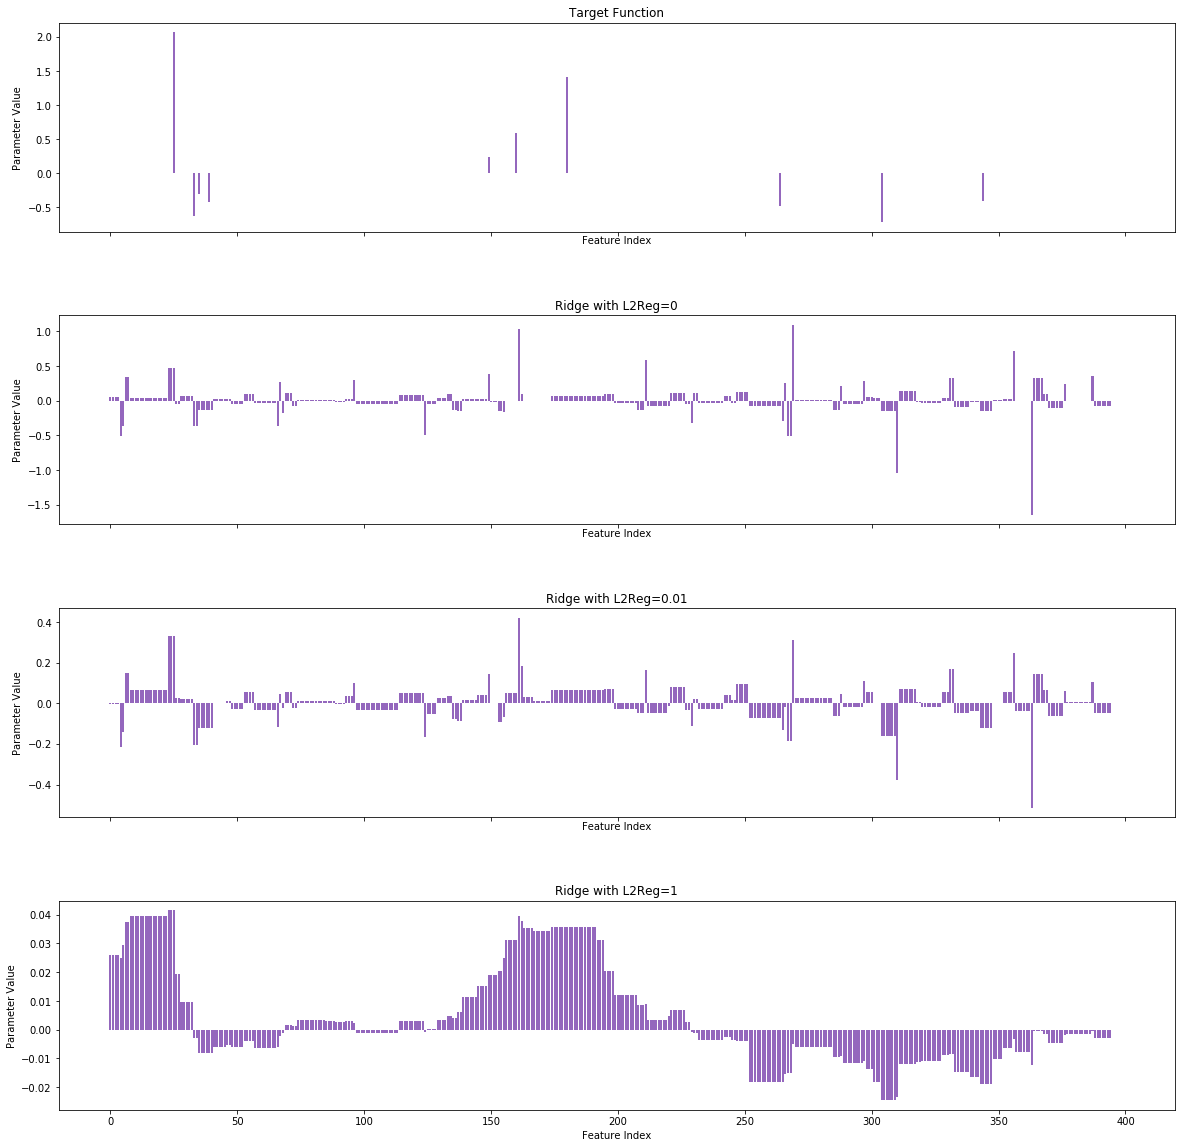

In [15]:
compare_parameter_vectors(pred_fns);

In ridge regression, we observe that by reducing the regularization parameter, we are introducing more sparsity in the weights. <br>
The co-efficients are more dense for $\lambda = 1$ and sparse for $\lambda = 0.01$. <br>
This is because the weight distribution of the paramters is more agressive in the case where $\lambda$ is small. <br>
From the scale of the co-efficients, we see that the weight is concentrated in only a few co-efficients for small $\lambda$, <br>
however for a large $\lambda$ this is distributed more evenly amongst the co-efficients.<br>

### Ridge Regression - Question 3

In [16]:
def plot_confusion_matrix(cm, title, classes):      
	 plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
	 plt.title(title)
	 plt.colorbar()
	 tick_marks = np.arange(len(classes))
	 plt.xticks(tick_marks, classes, rotation=45)
	 plt.yticks(tick_marks, classes)

	 thresh = cm.max() / 2.
	 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
		 plt.text(j, i, format(cm[i, j], 'd'),      
				  horizontalalignment="center",     
				  color="white" if cm[i, j] > thresh else "black")      

	 plt.tight_layout()        
	 plt.ylabel('True label')       
	 plt.xlabel('Predicted label')

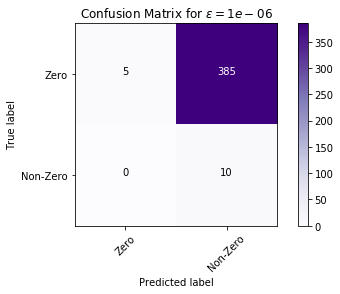

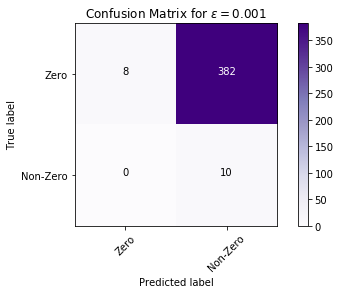

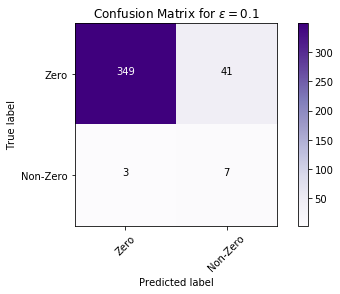

In [17]:
coefs_true_1 = pred_fns[2]['coefs']
bin_coefs_true = np.copy(coefs_true)
bin_coefs_true[bin_coefs_true != 0] = 1
eps_list = np.array([10**-6, 10**-3, 10**-1])
for eps in eps_list:
    bin_coefs_estimated = np.copy(coefs_true_1)
    bin_coefs_estimated[np.absolute(bin_coefs_estimated) < eps] = 0
    bin_coefs_estimated[np.absolute(bin_coefs_estimated) >= eps] = 1
    cnf_matrix = confusion_matrix(bin_coefs_true, bin_coefs_estimated)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])